## Library Setup

In [60]:
import os

import warnings

import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

%matplotlib inline
import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory


def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper


import warnings

warnings.filterwarnings("ignore")

__refresh__ = 1


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def categorise_input(X: pd.DataFrame):
    X.loc[:, nominal + ordinal] = X.loc[:, nominal + ordinal].astype("category")
    return X

KAGGLE_ENV = 1
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0
    
if KAGGLE_ENV==1:
    
    categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")
categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def find_correlated_features(df, threshold=0.8):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

        


In [61]:
class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

In [114]:
DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1
BENCHMARK_INPUT = '/kaggle/input/sub-sample/'

cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH
    BENCHMARK_INPUT = LOCAL_PATH + BENCHMARK_INPUT


def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

benchmark = pd.read_csv(BENCHMARK_INPUT+'sample.csv')

def make_submission(y):
    trial=0
    y_df = pd.DataFrame(y, columns=["label"])
    y_df.index.rename('id',inplace=True)
    y_df.to_csv(
        DATA_SAVE_PATH + "submission.csv",
    )
    if trial==0:
        benchmark.to_csv(DATA_SAVE_PATH+ "submission.csv")

@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info, inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info, inplace=True)
    raw_data.rename(columns={"label": "target"}, inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval


# rename_columns_with_dtype()
def reset_data():
    return rename_columns_with_dtype()
    

In [115]:
raw_data, raw_data_eval = reset_data()

In [64]:
X = raw_data.drop(["target"], axis=1)
y = raw_data.target

In [116]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

In [66]:
def baseline(raw_data=raw_data, test_size=0.5):
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    # quick_test(X)
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=test_size)

    random_forest = BalancedRandomForestClassifier(random_state=10)
    tmp_clf = make_pipeline(
        RFE(
            estimator=BalancedRandomForestClassifier(random_state=42),
            n_features_to_select=50,
        ),
        AdaBoostClassifier(
            base_estimator=random_forest, n_estimators=4, random_state=10
        ),
    )
    with parallel_backend("loky"):
        y_pred = tmp_clf.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred))
        scores = cross_validate(
            tmp_clf,
            X,
            y,
            cv=StratifiedKFold(n_splits=4),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        print("F1_Train", scores["train_score"].mean())
        print("F1_Test", scores["test_score"].mean())


baseline()

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       621
           1       0.79      0.81      0.80       932
           2       0.42      0.57      0.49       345

    accuracy                           0.71      1898
   macro avg       0.68      0.68      0.67      1898
weighted avg       0.74      0.71      0.72      1898

F1_Train 0.9797734685137968
F1_Test 0.6809945271904871


## Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using Quantile Transformeer__</mark>

In [150]:
__refresh__ = 1
raw_data, raw_data_eval = reset_data()

# @run_if_refresh
def update_ordinal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    categorical_columns = [ordinal, nominal]
    ordinal_data = raw_data.loc[:, ordinal].copy()
    ordinal_data_eval = raw_data_eval.loc[:, ordinal].copy()
    raw_data.loc[:, ordinal] = ordinal_data - ordinal_data.min()
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval - ordinal_data.min()
    # update_categorical_data()
    # disp = raw_data.loc[:, ordinal].min().plot(color="r", rot=90)
    # disp = raw_data_eval.loc[:, ordinal].min().plot(rot=90)
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

# @run_if_refresh
def ordinally_encode_nominal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval
# @run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data["binary_sum"] = raw_data.loc[:, binary].sum(axis=1)
    raw_data_eval["binary_sum"] = raw_data_eval.loc[:, binary].sum(axis=1)
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    # Define Scaling Method
    scaler1 = QuantileTransformer(
        output_distribution="normal", random_state=42, n_quantiles=1000
    )
    scaler2 = KBinsDiscretizer(
        encode="onehot-dense", random_state=10, n_bins=3, strategy="kmeans"
    )
    # mscaler = make_pipeline(scaler1,scaler2)
    mscaler = StandardScaler()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # New Column Names
    new_ordinal_col_names = mscaler.get_feature_names_out()
    new_ordinal_col_names = [x.replace(".", "_") for x in new_ordinal_col_names]
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    ).astype("int") + 1
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    ).astype("int") + 1
    # Concatenate in place
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ratios, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ratios, axis=1)], axis=1
    )
    # Write modified data to disk
    # write_raw_data(raw_data, raw_data_eval)
    # return raw_data
    return raw_data, raw_data_eval
    

@run_if_refresh
def apply_transformations():
    raw_data, raw_data_eval = reset_data()

    raw_data, raw_data_eval = update_ordinal_data(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = sort_columns_by_name(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = ordinally_encode_nominal_data(raw_data, raw_data_eval)    
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = binary_feature_sum(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = standardise_ratio_features(raw_data, raw_data_eval)
    write_raw_data(raw_data, raw_data_eval)
    
    
apply_transformations()
raw_data, raw_data_eval = reload_raw_data()


def refresh_data():
    global __refresh__
    __refresh__ = 1
    raw_data, raw_data_eval = reset_data()
    # rename_columns_with_dtype()
    apply_transformations()
    raw_data, raw_data_eval = reload_raw_data()
    __refresh__ = 0
    print("Data Refresh Success")
    return raw_data, raw_data_eval
    
# raw_data, raw_data_eval = refresh_data()


def create_target_encoding():
    new_column_names = []
    stubs = ["_0","_1","_2"]
    for c in ordinal+nominal:
        for _suffix in stubs:
            new_column_names.append(c+_suffix)
    df_train = pd.DataFrame(index=raw_data.index,columns=new_column_names)
    df_eval = pd.DataFrame(index=raw_data_eval.index,columns=new_column_names)
    for c in ordinal+nominal:
        target_counts = raw_data.groupby(c)['target'].value_counts().unstack(fill_value=0)
        tf: pd.DataFrame = target_counts.loc[:,[0,1,2]]
        target_counts['sum'] = tf.sum(axis=1)
        target_counts['std'] = tf.std(axis=1)
        # target_counts['std'] = 
        tf2 = tf.subtract(target_counts['std'],axis='rows')
        tf2 = tf2.divide((target_counts['sum']-target_counts['std']),axis='rows')
        target_map = {0:0,1:1,2:2}
        for val in target_map:
            mapping = defaultdict(int,tf2.to_dict()[target_map[val]])
            df_train[c+stubs[val]] = raw_data[c].map(mapping)
            df_eval[c+stubs[val]] = raw_data_eval[c].map(mapping)
    return df_train, df_eval
target_encoded_train, target_encoded_eval  = create_target_encoding()    


In [151]:
# binary_feature_sum()
# raw_data, raw_data_eval = reload_raw_data()
raw_data.columns

Index(['ratio__v_16', 'ratio__v_2', 'ratio__v_34', 'ratio__v_35',
       'ratio__v_36', 'ratio__v_37', 'ratio__v_38', 'ratio__v_39',
       'ratio__v_40', 'ratio__v_7', 'ratio__v_8', 'binary__v_1',
       'binary__v_11', 'binary__v_14', 'binary__v_26', 'binary__v_27',
       'binary__v_28', 'binary__v_30', 'binary__v_9', 'nominal__v_12',
       'nominal__v_18', 'nominal__v_20', 'nominal__v_21', 'nominal__v_25',
       'nominal__v_3', 'nominal__v_32', 'nominal__v_4', 'ordinal__v_0',
       'ordinal__v_10', 'ordinal__v_13', 'ordinal__v_15', 'ordinal__v_17',
       'ordinal__v_19', 'ordinal__v_22', 'ordinal__v_23', 'ordinal__v_24',
       'ordinal__v_29', 'ordinal__v_31', 'ordinal__v_33', 'ordinal__v_5',
       'ordinal__v_6', 'target', 'binary_sum'],
      dtype='object')

In [152]:
raw_data

,ratio__v_16,ratio__v_2,ratio__v_34,ratio__v_35,ratio__v_36,ratio__v_37,ratio__v_38,ratio__v_39,ratio__v_40,ratio__v_7,ratio__v_8,binary__v_1,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_28,binary__v_30,binary__v_9,nominal__v_12,nominal__v_18,nominal__v_20,nominal__v_21,nominal__v_25,nominal__v_3,nominal__v_32,nominal__v_4,ordinal__v_0,ordinal__v_10,ordinal__v_13,ordinal__v_15,ordinal__v_17,ordinal__v_19,ordinal__v_22,ordinal__v_23,ordinal__v_24,ordinal__v_29,ordinal__v_31,ordinal__v_33,ordinal__v_5,ordinal__v_6,target,binary_sum
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,2,2,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0.0,25.0,17.0,0.0,4.0,10.0,0.0,18.0,0,6,0,2,7,6,15,0,0,16,1,6,6,6,1,3
1,2,2,1,1,1,1,2,1,2,1,1,1,0,1,1,0,0,1,1,6.0,74.0,49.0,5.0,3.0,119.0,33.0,28.0,1,7,9,3,14,9,14,1,4,12,2,7,15,5,2,5
2,1,1,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,1,0,0.0,25.0,95.0,0.0,0.0,20.0,74.0,76.0,0,6,0,1,7,6,12,0,0,13,6,6,6,4,1,4
3,1,1,1,1,1,1,1,2,0,1,1,1,1,0,0,1,0,0,1,0.0,18.0,0.0,0.0,0.0,44.0,0.0,57.0,0,8,0,4,7,7,12,0,0,13,1,7,9,7,1,4
4,4,3,4,1,1,1,1,1,1,1,3,1,0,0,1,0,0,1,1,6.0,51.0,44.0,1.0,42.0,33.0,11.0,6.0,2,13,19,9,20,23,17,4,13,23,24,18,19,19,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,1,1,1,1,2,2,0,1,1,0,1,1,1,0,0,1,0,1,0,0.0,18.0,0.0,0.0,0.0,10.0,28.0,47.0,0,6,0,4,7,5,12,0,0,12,2,6,12,2,2,4
3792,1,3,3,1,1,2,2,2,2,1,1,1,0,1,1,1,0,1,1,9.0,24.0,4.0,4.0,5.0,33.0,2.0,66.0,3,16,8,11,14,9,17,0,0,18,5,11,13,16,2,6
3793,1,1,2,1,1,2,0,2,2,1,3,1,0,1,1,1,0,1,1,7.0,23.0,50.0,2.0,0.0,31.0,76.0,22.0,8,14,3,5,16,7,19,5,9,19,5,9,18,3,0,6


In [153]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

In [154]:
mod_ord_nom = [
    # 'nominal__v_12',
 'nominal__v_18',
 'nominal__v_20',
 # 'nominal__v_21',
 'nominal__v_25',
 'nominal__v_3',
 'nominal__v_32',
 'nominal__v_4',
 # 'ordinal__v_0',
 'ordinal__v_10',
 # 'ordinal__v_13',
 'ordinal__v_15',
 'ordinal__v_17',
 'ordinal__v_19',
 'ordinal__v_22',
 # 'ordinal__v_23',
 # 'ordinal__v_24',
 'ordinal__v_29',
 'ordinal__v_31',
 'ordinal__v_33',
 'ordinal__v_5',
 'ordinal__v_6'
]

```python
disp = ordinal_data.plot(kind='kde',subplots = True, figsize=(10,20), sharex=True)
disp = nominal_data.plot(kind='kde',subplots = True, figsize=(10,20), sharex=True)
disp = binary_data.plot(kind='kde',subplots = True, figsize=(10,20), sharex=True)
disp = ratios_data.plot(kind='kde',subplots = True, figsize=(10,20), sharex=True)
```

![Image](../imgs/kde_combined.png)

<AxesSubplot:>

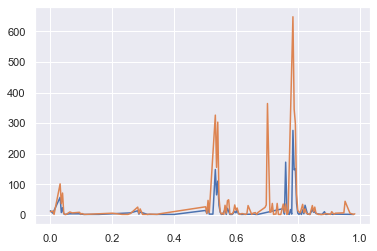

In [380]:
binary_mod = [
    'binary__v_1',
    'binary__v_11',
    'binary__v_14',
    'binary__v_26',
    'binary__v_27',
    'binary__v_28',
    'binary__v_30',
    'binary__v_9'
]
raw_binary_mod = raw_data.loc[:, binary_mod]
b_lit_train = pd.DataFrame(columns=["bin_literal"], index=raw_data.index)
b_lit_eval  = pd.DataFrame(columns=["bin_literal"], index=raw_data_eval.index)
raw_data['bin_literal']  = "0"
raw_data_eval['bin_literal']  = "0"
def gen_binary_literal(row):
    bin_chr = [str(row[b]) for b in binary_mod]
    # b_l  = ''.join(bin_chr)
    b_l = ""
    for c in bin_chr:
        b_l+=c
    # assert type(row['id']) == 'int'
    # print(b_l)
    row.bin_literal = int(b_l,2)/255
    return row

raw_data = raw_data.apply(gen_binary_literal,axis=1)
raw_data_eval= raw_data_eval.apply(gen_binary_literal,axis=1)
bin_lit_dist = raw_data.groupby(['bin_literal'])['target'].value_counts().unstack(fill_value=0)
# raw_data.groupby(['bin_literal'])['target'].value_counts().unstack(fill_value=0)
# pd.DataFrame.unstack()
raw_data_eval.bin_literal.sort_values().value_counts().sort_index().plot()
raw_data.bin_literal.value_counts().sort_index().plot()


In [381]:
bin_sum_dist_train = raw_data.groupby(['binary_sum','bin_literal'])['target'].value_counts().unstack(fill_value=0)
bin_sum_dist_eval  = raw_data_eval.groupby(['binary_sum'])['bin_literal'].value_counts()

In [382]:
# OneHotEncoder(categories=)
bin_sum_dist_eval

binary_sum  bin_literal
0           0.000000       13
1           0.031373       57
            0.501961       14
            0.007843        5
            0.062745        3
                           ..
5           0.913725        1
6           0.858824        4
            0.811765        1
            0.980392        1
7           0.874510        1
Name: bin_literal, Length: 84, dtype: int64

In [383]:
b_lit_categories = list(set(raw_data_eval.bin_literal.unique()).union(set(raw_data.bin_literal.unique())))

In [365]:
# tmp = raw_data.loc[: , ['bin_literal','binary_sum']]
# tmp = pd.concat([tmp, pd.get_dummies(raw_data.binary_sum)])
# ohe_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# ohe_enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
# tmp = raw_data.loc[: , ['bin_literal']+binary]
# tmp_eval = raw_data_eval.loc[: , ['binary_sum','bin_literal']+binary]
# tmp_t = ohe_enc.fit_transform(tmp)
# tmp_t_eval = ohe_enc.transform(tmp_eval)

# # tmp_y = pd.get_dummies(raw_data.binary_sum)
# tmp_y2 = pd.get_dummies(raw_data.bin_literal)
# tmp = pd.concat([binary_data, tmp_y2], axis=1)
# tmp

,binary__v_1,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_28,binary__v_30,binary__v_9,0,2,3,8,9,10,11,12,13,16,18,24,25,26,28,51,59,...,208,209,210,211,212,214,216,217,218,219,221,225,226,227,231,232,233,234,235,241,242,243,247,250,251
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3792,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3793,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


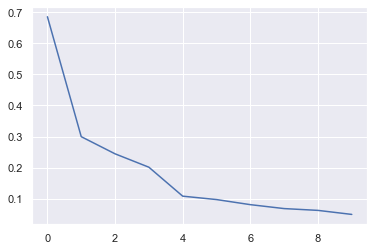

In [384]:
dime = PCA(n_components=10)
tmp_t = dime.fit_transform(tmp)
plt.plot(dime.explained_variance_)

In [345]:
# tmp_3 = mca.transform(tmp)

In [351]:
tmp_3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.483738,0.332486,0.487932,-0.077177,-1.084559,-0.240594,-0.060044,-0.084242,-0.133779,-0.043844,-0.085422,0.113071,0.193877,0.121745,-0.064862,-0.074316,0.000452,-0.144387,-0.060410,0.016693,0.088447,-0.025285,0.113168,-0.165619,0.046037,0.156371,0.276029,0.051223,-0.268723,0.062856,0.054564,0.135000,-0.036223,-0.055099,-0.021893,0.042897,-0.041990,-0.034210,-0.277505,0.085321,0.041099,-0.062613,-0.171807,-0.081377,-0.032921,-0.132920,-0.107613,0.137813,-0.124611,0.101211
1,-1.053001,-0.807396,-1.926755,0.319868,0.193339,0.236074,0.162322,-0.260817,-0.121758,0.049826,0.118910,0.157214,0.149931,-0.070014,-0.264112,-0.170457,-0.037476,0.037446,-0.190374,0.047085,0.013248,0.109565,-0.015836,0.098549,0.259795,0.015875,0.139780,0.109084,0.225889,-0.094867,0.213271,0.056565,-0.151504,-0.070358,-0.021018,0.157214,0.064323,0.107021,-0.029495,-0.008408,0.058786,-0.042939,0.126546,-0.111713,-0.041725,-0.056538,0.122365,-0.149044,0.078047,0.069880
2,0.946942,0.339642,-0.082350,-0.174062,0.638861,-0.530373,1.047181,0.222669,-0.030061,-0.012291,-0.095477,-0.357470,-0.240402,-0.033071,-0.010912,-0.245013,-0.111333,-0.227854,-0.052569,0.294747,0.047224,-0.386157,0.090947,0.091590,-0.046179,0.312873,-0.149733,0.128750,0.106632,0.066718,-0.031944,0.044712,0.066251,-0.069895,0.158479,-0.142272,0.004245,0.380548,-0.119975,-0.381031,-0.201486,-0.071981,-0.038408,0.157376,-0.140456,-0.051915,-0.100799,0.036510,0.156424,-0.017854
3,0.946942,0.339734,-0.082330,-0.174018,0.638387,-0.530286,1.046930,-0.111563,-0.110652,0.000610,0.051015,0.077443,0.031297,0.188350,-0.098791,0.135697,-0.081860,0.042660,0.393950,0.135875,0.324200,0.192089,-0.117886,0.012708,-0.067924,-0.082227,-0.144654,-0.259886,-0.070378,0.007395,0.041149,0.239843,-0.172668,-0.077019,-0.367911,0.030623,-0.198313,-0.262744,0.063241,0.422645,-0.014109,-0.002906,-0.062867,0.196341,0.137721,-0.046139,0.016069,-0.301167,0.124566,-0.083455
4,0.946969,0.339554,-0.082837,-0.174034,0.638483,-0.530658,1.046856,-0.669383,0.022310,0.046608,-0.693958,0.269469,0.360779,0.152210,-0.375988,-0.663452,-0.170395,0.074957,-0.514935,0.078459,-0.406049,0.342887,-0.168068,-1.147646,1.020952,-0.626630,-0.584541,-0.392764,0.255952,-0.493660,-0.302043,-0.143122,-0.187651,0.131053,0.310306,0.325967,-0.134217,-0.306743,-0.013447,-0.760352,0.453040,-0.077038,-0.684455,-0.635088,0.469607,-0.293832,-0.542244,0.516864,-1.118746,0.179271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,0.946942,0.339642,-0.082350,-0.174062,0.638861,-0.530373,1.047181,0.222669,-0.030061,-0.012291,-0.095477,-0.357470,-0.240402,-0.033071,-0.010912,-0.245013,-0.111333,-0.227854,-0.052569,0.294747,0.047224,-0.386157,0.090947,0.091590,-0.046179,0.312873,-0.149733,0.128750,0.106632,0.066718,-0.031944,0.044712,0.066251,-0.069895,0.158479,-0.142272,0.004245,0.380548,-0.119975,-0.381031,-0.201486,-0.071981,-0.038408,0.157376,-0.140456,-0.051915,-0.100799,0.036510,0.156424,-0.017854
3792,-1.823518,2.926320,0.253996,-0.398278,3.033842,-0.555584,-2.433789,-0.365677,0.909673,0.247573,-0.370416,0.628294,-0.781854,-0.017440,-0.108483,-0.244069,0.380375,1.318762,-0.280606,0.849042,0.018431,0.460513,-0.115774,-0.982570,-0.460383,0.651232,0.494560,-0.397077,-0.027716,0.922856,-0.514977,0.498147,-0.505785,-0.160388,-0.095813,-0.128999,0.236483,0.094828,0.340529,0.247414,-0.217115,-0.041960,0.172851,1.132102,-0.490728,0.523240,0.434444,-0.881854,-0.999261,1.442727
3793,-1.823518,2.926320,0.253996,-0.398278,3.033842,-0.555584,-2.433789,-0.365677,0.909673,0.247573,-0.370416,0.628294,-0.781854,-0.017440,-0.108483,-0.244069,0.380375,1.318762,-0.280606,0.849042,0.018431,0.460513,-0.115774,-0.982570,-0.460383,0.651232,0.494560,-0.397077,-0.027716,0.922856,-0.514

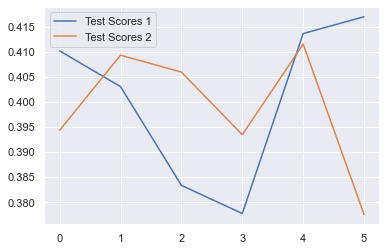

In [386]:
clf = DecisionTreeClassifier(random_state=10)

transformed_bin_scores = cross_validate(clf,tmp,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores 1')
# disp = plt.plot(transformed_bin_scores['train_score'],label='Train Scores 1')

clf = DecisionTreeClassifier(random_state=10)

transformed_bin_scores = cross_validate(clf,binary_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores 2')
# disp = plt.plot(transformed_bin_scores['train_score'],label='Train Scores 2')
plt.legend()

In [376]:
for c in binary:
    print(raw_data[c].value_counts())

1    3460
0     336
Name: binary__v_1, dtype: int64
0    2026
1    1770
Name: binary__v_11, dtype: int64
0    3115
1     681
Name: binary__v_14, dtype: int64
0    2801
1     995
Name: binary__v_26, dtype: int64
1    2777
0    1019
Name: binary__v_27, dtype: int64
0    3642
1     154
Name: binary__v_28, dtype: int64
0    2036
1    1760
Name: binary__v_30, dtype: int64
0    2374
1    1422
Name: binary__v_9, dtype: int64


In [387]:
raw_data.corrwith(raw_data.target).sort

ratio__v_16      0.002802
ratio__v_2      -0.034784
ratio__v_34     -0.009356
ratio__v_35     -0.000249
ratio__v_36      0.017504
ratio__v_37     -0.011946
ratio__v_38      0.003885
ratio__v_39     -0.009856
ratio__v_40     -0.010739
ratio__v_7      -0.037962
ratio__v_8      -0.026589
binary__v_1      0.055830
binary__v_11     0.047513
binary__v_14    -0.012573
binary__v_26    -0.102939
binary__v_27     0.225127
binary__v_28     0.002742
binary__v_30    -0.113133
binary__v_9      0.064009
nominal__v_12    0.010735
nominal__v_18    0.032987
nominal__v_20   -0.044052
nominal__v_21   -0.042645
nominal__v_25   -0.074529
nominal__v_3     0.042782
nominal__v_32   -0.084709
nominal__v_4    -0.026117
ordinal__v_0    -0.035275
ordinal__v_10    0.029318
ordinal__v_13   -0.006180
ordinal__v_15    0.012123
ordinal__v_17    0.098969
ordinal__v_19    0.215180
ordinal__v_22    0.368522
ordinal__v_23   -0.019353
ordinal__v_24   -0.030006
ordinal__v_29    0.293508
ordinal__v_31   -0.198527
ordinal__v_3